In [2]:
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from typing import TypedDict, Annotated
from langgraph.graph import StateGraph, add_messages, END
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver

load_dotenv()

memory = MemorySaver()

class BasicChatBot(TypedDict):
    messages: Annotated[list, add_messages]

search_tool = TavilySearchResults(max_results=2)

tools = [search_tool]

llm = ChatGroq(model = "llama-3.1-8b-instant")
llm_with_tools = llm.bind_tools(tools=tools)

# response = llm_with_tools.invoke("What is the capital of China?")
# print(response)

def Chatbot(state: BasicChatBot):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

def tools_router(state: BasicChatBot):
    last_message = state["messages"][-1]

    if (hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0):
        return "tool_node"
    else:
        return END

tool_node = ToolNode(tools=tools, messages_key="messages")

graph = StateGraph(BasicChatBot)
graph.add_node("tool_node", tool_node)
graph.add_node("chatbot", Chatbot)
graph.set_entry_point("chatbot")
graph.add_conditional_edges("chatbot", tools_router)
graph.add_edge("tool_node", "chatbot")

app = graph.compile(checkpointer=memory, interrupt_before=["tool_node"])


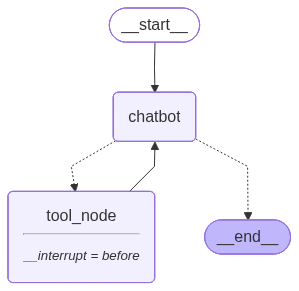

In [3]:
from IPython.display import display, Image

display(Image(app.get_graph().draw_mermaid_png()))

In [4]:
config = {"configurable": {"thread_id": 1}}

events = app.stream({
    "messages": [HumanMessage("What is the current weather in Colombo?")]
}, config=config, stream_mode="values")

for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

What is the current weather in Colombo?
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (77h99qjxg)
 Call ID: 77h99qjxg
  Args:
    query: current weather in Colombo


In [5]:
snapshot = app.get_state(config=config)
snapshot.next

('tool_node',)

In [6]:
events = app.stream(None, config=config, stream_mode="values")
for event in events:
    event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (77h99qjxg)
 Call ID: 77h99qjxg
  Args:
    query: current weather in Colombo
================================= Tool Message =================================
Name: tavily_search_results_json

[{"url": "https://weatherspark.com/h/m/109720/2025/11/Historical-Weather-in-November-2025-in-Colombo-Sri-Lanka", "content": "Observed Weather in November 2025 in Colombo ; Wed, Nov 12, Recent Showers of Rain, Showers of Light Rain, RESHRA, -SHRA ; Thu, Nov 13, Recent Showers of Rain"}, {"url": "https://www.metcheck.com/WEATHER/dayforecast.asp?location=Colombo&locationID=870953&lat=45.477150&lon=10.226400&dateFor=11/12/2025", "content": "Time, Weather, Temp, Feels, RainRisk, Amount, Cloud, Dir, Speed, Gust, RH, UV. 0:00, 5 °c, 5 °c, 0%, 0.0mm, 68%, 2mph, 5mph, 83%, 0."}]
================================== Ai Message ==================================

The current weather in Col